# **Neural Networks (NNs) for growth-rate $f\sigma_8$ data model classification**
## [Hu-Sawicki](https://arxiv.org/abs/1811.02469) vs ΛCDM
Test subtle deviations beyond ΛCDM at the level of Large Scale Structure, galaxy clustering data. 
Hu-Sawicki context:

\begin{equation}
f(R)=-6 \Omega_{\mathrm{DE}, 0} \frac{H_0^2}{c^2}+\left|f_{R 0}\right| \frac{\bar{R}_0^2}{R}+\ldots,
\end{equation}

where $f_{R 0}=\mathrm{d} f(R) /\left.\mathrm{d} R\right|_{z=0}$ and the background expansion history is the one of ΛCDM.

In [1]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks
from matplotlib import pyplot as plt

### Read the data:
It was simulated out of perturbation theory in the context of the density field $\delta_m$ for two cases: ΛCDM and HS. For the uncertainities, we simulated a DESI-like covariance matrix with SoapFish and considered the fiducial value $\mid f_{R0} \mid=5\times 10^{-6}$.

In [2]:
dataframe = pd.read_csv('./data/fs8_fR0_Training_5000samples.csv')
dataframe.shape

(3516, 17)

In [3]:
dataframe.head()

,fs8_1,fs8_2,fs8_3,fs8_4,fs8_5,fs8_6,fs8_7,fs8_8,fs8_9,fs8_10,fs8_11,fs8_12,fs8_13,fs8_14,fs8_15,fs8_16,target
0,0.432408,0.362341,0.471745,0.474433,0.504194,0.465221,0.455875,0.436661,0.446206,0.412953,0.402137,0.414584,0.406408,0.369243,0.377376,0.294151,1
1,0.430966,0.353532,0.455968,0.452442,0.476919,0.430236,0.418315,0.397230,0.405487,0.371418,0.360164,0.372472,0.364388,0.327491,0.336029,0.253309,0
2,0.396919,0.328377,0.439995,0.445306,0.477860,0.444334,0.437447,0.420456,0.431977,0.400457,0.391148,0.404899,0.397846,0.361645,0.370607,0.288093,0
3,0.386137,0.321902,0.438130,0.448024,0.484890,0.458620,0.454577,0.439919,0.453307,0.423243,0.415040,0.429599,0.423111,0.387273,0.396437,0.313993,1
4,0.458515,0.377975,0.476976,0.469988,0.491183,0.438906,0.424745,0.401779,0.408481,0.373144,0.360867,0.372356,0.363623,0.326216,0.334355,0.251325,1


In [4]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 2813 samples for training and 703 for validation


### Setting up and training the deep neural networks

In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

In [7]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [8]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    #Normalization layer
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

In [9]:
int((len(dataframe.columns)))

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'fs8_1': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.46232811, 0.48125581, 0.44839775, 0.43839501, 0.39688002,
       0.4014991 , 0.46701078, 0.48082931, 0.49141625, 0.50464104,
       0.35375779, 0.37857984, 0.4572614 , 0.41534815, 0.52317173,
       0.43817366, 0.42103527, 0.34608255, 0.46454211, 0.32474345,
       0.4448869 , 0.34406632, 0.35929046, 0.34226929, 0.45245846,
       0.47158784, 0.4102044 , 0.33867091, 0.4582002 , 0.52532364,
       0.3226345 , 0.46418089])>, 'fs8_2': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.39575014, 0.40308428, 0.37760457, 0.36237755, 0.32536654,
       0.33462234, 0.39586075, 0.41115351, 0.41591363, 0.43143703,
       0.28410957, 0.30903829, 0.38013577, 0.35230087, 0.45085849,
       0.35962964, 0.34814864, 0.27893516, 0.39201177, 0.25951854,
       0.37200309, 0.27550124, 0.28894696, 0.27749176, 0.38747136,
       0.39486765, 0.34096817, 0.27318413, 0.38721852, 0.45119019,
       0.25597544, 0.38475832])>, 'fs8_3':

In [10]:
from keras.optimizers import Nadam

all_inputs = []
all_features_encoded = []

for i in range(1, int((len(dataframe.columns)))):
    fs_input = keras.Input(shape=(1,), name=f"fs8_{i}")
    fs_encoded = encode_numerical_feature(fs_input, f"fs8_{i}", train_ds)
    all_inputs.extend([fs_input])
    all_features_encoded.extend([fs_encoded])

#Concatenate encoded features
all_features = layers.concatenate(all_features_encoded)

#Layers
x = layers.Dense(16, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

#The model
model = keras.Model(all_inputs, output)

model.compile(optimizer='nadam', loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [11]:
#Check how the model is structured
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fs8_1 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 fs8_2 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 fs8_3 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 fs8_4 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                              

In [12]:
#Training
NCC_1701_D=model.fit(train_ds, epochs=2000, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/2000
88/88 [==============================] - 1s 4ms/step - loss: 0.7298 - accuracy: 0.5172 - val_loss: 0.6825 - val_accuracy: 0.5861
Epoch 2/2000
88/88 [==============================] - 0s 2ms/step - loss: 0.7115 - accuracy: 0.5382 - val_loss: 0.6789 - val_accuracy: 0.5789
Epoch 3/2000
88/88 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5403 - val_loss: 0.6790 - val_accuracy: 0.5690
Epoch 4/2000
88/88 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.5489 - val_loss: 0.6789 - val_accuracy: 0.5605
Epoch 5/2000
88/88 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5421 - val_loss: 0.6765 - val_accuracy: 0.5761
Epoch 6/2000
88/88 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5563 - val_loss: 0.6766 - val_accuracy: 0.5647
Epoch 7/2000
88/88 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5549 - val_loss: 0.6764 - val_accuracy: 0.5676
Epoch 

### Learning curves

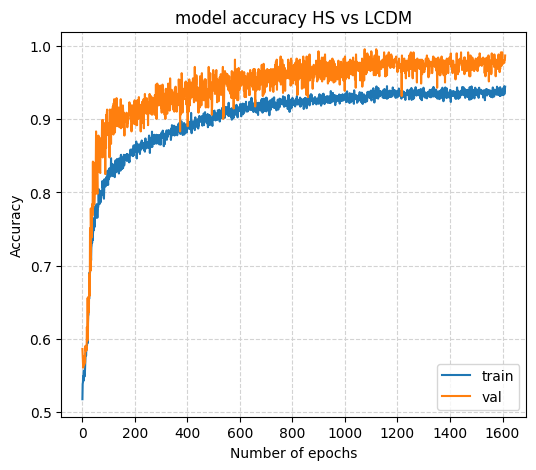

In [13]:
fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['accuracy'])
plt.plot(NCC_1701_D.history['val_accuracy'])
plt.title('model accuracy HS vs LCDM')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.grid(color='lightgray', linestyle='--')
plt.show()
fig.savefig('./figures/HS_acc_t1.png')

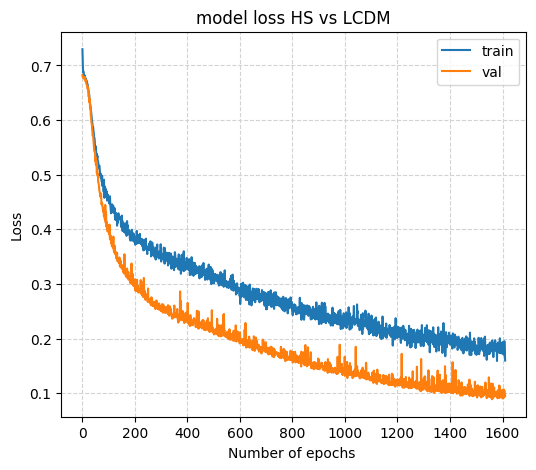

In [14]:
fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['loss'])
plt.plot(NCC_1701_D.history['val_loss'])
plt.title('model loss HS vs LCDM')
plt.ylabel('Loss')
plt.xlabel('Number of epochs ')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(color='lightgray', linestyle='--')
plt.show()
fig.savefig('./figures/HS_loss_t1.png')

In [15]:
#Probability of data realization of belonging to class HS
def norm(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

In [16]:
theory = ['LCDM','MoG']

with open('./data/fs8_fR0_Test_5000samples.csv', 'r') as f:
    dict_reader = csv.DictReader(f,quoting=csv.QUOTE_NONNUMERIC)
    test_models = list(dict_reader)

### Testing the NNs

In [17]:
true_model=[]
pred_model=[]
prob_pred=[]
for i in range(len(test_models)):
  sample = test_models[i]
  true_model.append(round(test_models[i]['target']))
  sample.pop('target', None)
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()} 
  predictions = model.predict(input_dict)
  pred_model.append(round(predictions[0][0]))
  prob_pred.append(round(100*norm(predictions[0][0]),3)) #Probability of belonging to class 1: HS

1/1 [==============================] - 0s 66ms/step


In [18]:
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []
for i in range(len(test_models)):
  if(true_model[i]==pred_model[i] and pred_model[i]==0):
    true_LCDM.append(1)
  if(true_model[i]==pred_model[i] and pred_model[i]==1):
    true_MoG.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==0):
    false_LCDM.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==1):
    false_MoG.append(1)  
lens= [len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]
print(lens)
print(sum(lens))

[746, 722, 39, 0]
1507


### Performance verification of the NNs

In [19]:
print('     ','LCDM','f(R)')
print('True ',len(true_LCDM)/sum(lens),len(true_MoG)/sum(lens))
print('False',len(false_LCDM)/sum(lens),len(false_MoG)/sum(lens))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lens))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lens))

      LCDM f(R)
True  0.49502322495023227 0.47909754479097544
False 0.025879230258792303 0.0
--------------
Correct prediction:  0.9741207697412076
Wrong prediction  :  0.025879230258792303


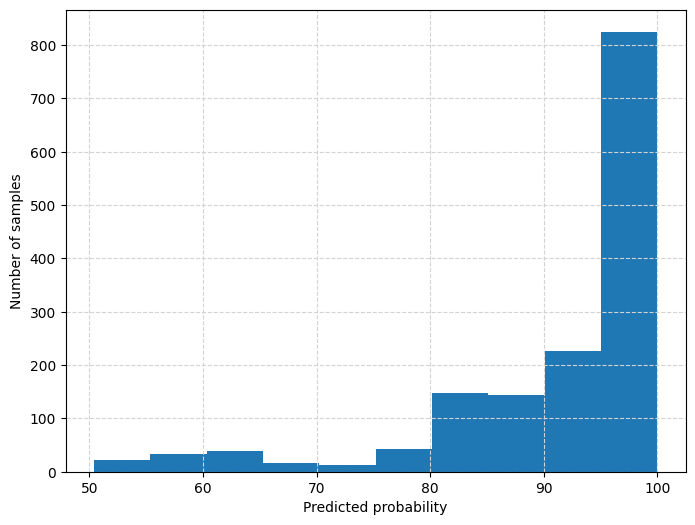

In [20]:
fig = plt.figure(figsize=(8,6))
plt.hist(prob_pred)
plt.grid(color='lightgray', linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')

fig.savefig('./figures/HS_hist_t1.png')
plt.show()

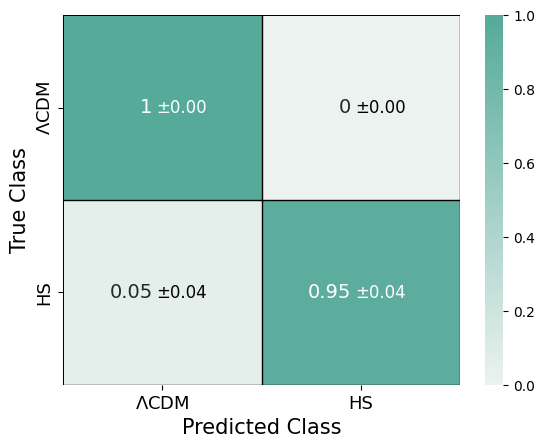

In [21]:
#Confusion matrix
from sklearn import metrics
import seaborn as sns

cm = metrics.confusion_matrix(true_model, pred_model)
mean_values = np.array([[1., 0.],
                   [0.05, 0.95]])

#Mean values and errors
errors = np.array([[0., 0.],
                   [0.04, 0.04]])

#Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 3)

cmap = sns.color_palette("light:#5A9", as_cmap=True)

ax = sns.heatmap(mean_values, cmap=cmap, linewidths=0.6, linecolor='black',
            annot=True,  annot_kws={"size": 14},
            xticklabels=['$\Lambda$CDM', 'HS'],
            yticklabels=['$\Lambda$CDM', 'HS'])

for text in ax.texts:
    text.set_ha('right')
    text.set_x(text.get_position()[0] - 0.05)

#The errors (Computed from 15 repetitions)
for i in range(len(mean_values)):
    for j in range(len(mean_values[0])):
        text_color = 'black' if mean_values[i,j] < 0.5 else 'white'  
        ax.text(j + 0.47, i + 0.5, f'±{errors[i, j]:.2f}', ha="left", va="center", color=text_color, fontsize=12)

for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.add_line(plt.Line2D([j + 1, j + 1], [i, i + 1], color='black', linewidth=1))
        ax.add_line(plt.Line2D([j, j + 1], [i + 1, i + 1], color='black', linewidth=1))

plt.xlabel('Predicted Class',fontsize=15)
plt.ylabel('True Class',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.savefig('./figures/HS_conf_matrix.png')
plt.show()